# Face Identification and Adversarial Attacks
**Projet Deep Learning for Images**

Auteurs : Elise Chin, Mathilde Da Cruz


# Abstract

L'objectif de ce projet est de réaliser un système d'attaque adverse dans le domaine de l'identification faciale dans un contexte closed-set. Notre choix du dataset s'est porté sur LFW. Dans un premier temps, nous développons un modèle de classification qui sera par la suite attaqué. Pour ce faire, nous passerons par l'intermédiaire d'un modèle de vérification, qui devra être capable de dire si deux images sont des photos de la même personne ou non. Lors d'une tâche de vérification classique, le modèle calcule un score de similarité, et décide que deux images représentent la même personne si le score est au dessus d'un certain seuil. Pour classifier une image, nous utiliserons ce modèle pour comparer l'image en question à toutes les autres images du dataset, mais plutôt que d'utiliser un seuil, nous garderons les scores de similarité pour chaque image comparée. À la fin, le label donné à l'image de départ sera le label de l'image du dataset la plus similaire. Dans un second temps, nous développons un type d'attaque adverse, et plus précisemment nous générons des images visuellement très similaires aux images originales à l'aide de l'algorithme FGSM. Cette attaque est de type white-box, c'est-à-dire que nous avons accès au modèle pour générer les attaques, et s'applique lors de la phase d'inférence, donc nous perturbons les images de la gallerie de test afin de tromper le modèle et réduire sa performance. Enfin, nous tâcherons également de discuter des différents choix de paramètres, notamment des choix de métriques pour l'évaluation.

# Introduction

La tâche que l'on souhaite résoudre ici est une tâche d'identification (*Face Identification*) : étant donné l'image d'un visage d'une personne inconnue, on souhaite identifier le nom de cette personne en se basant sur une banque d'images de personnes déjà identifiées. Nous nous plaçons dans un contexte closed-set : nous savons donc déjà que la personne que l'on veut identifier est une des personnes de notre banque d'images. On peut voir le problème comme une tâche de classification multi-classe, où chaque classe représente une personne (un label est le nom d'une personne).


__Première idée__

Traditionnellement, pour résoudre une tâche de classification d'images, on entraîne un CNN qui prend en entrée une image et donne en sortie une distribution de probabilités sur les classes, à l'aide d'un classifieur softmax.

Il y a cependant plusieurs limites à cette approche dans certains cas : 
- Si le dataset possède des centaines voir des milliers de classes (en l'occurrence pour LFW, il y a 5749 classes dont 1680 classes avec au moins deux images distinctes), utiliser un classifieur softmax engendrera des calculs très coûteux et un entraînement long. Nous disposons dans le cadre de ce projet d'un temps très limité.
- Si le dataset est très déséquilibré, ce qui est notamment le cas de LFW où la majorité des classes n'ont qu'une seule image, apprendre des caractéristiques de chaque visage posera problème pour le modèle du à un manque de données. 

__Deuxième idée__

Au lieu de suivre l'approche traditionnelle, une autre manière de résoudre le problème est de partir d'une tâche de vérification de visages (*Face verification*). L'idée ici est de reconnaître si deux images $x_1$ et $x_2$ correspondent ou non à la même personne. Pour cela, on calcule un score de similarité entre ces deux images, et si la valeur est au dessus d'un certain seuil, alors on considérera que les deux images représentent la même personne. 


Les modèles siamois permettent de résoudre cette tâche. Ce modèle prend en entrée deux images et renvoie un score de similarité (en l'occurrence la similarité cosinus). On l'entraîne en minimisant la contrastive loss.

Les réseaux siamois présentent plusieurs avantages :
- Fonctionne avec peu de données : en effet, à partir d'un set d'images on peut créer de nombreuses paires différentes (2 parmi $n$) ce qui permettra de créer un ensemble d'entraînement beaucoup plus conséquent.
- Robuste au déséquilibre du jeu de données : le réseau siamois peut apprendre à reconnaître un visage avec peu d'images d'entraînement. 

Notons que notre tâche est une tâche de classification binaire (s'agit-il de la même personne, oui ou non). Comment donc passer de face verification à face identification ?

Nous pouvons formuler la requête suivante : 

Soit $x$ une image qu'on souhaite classifier. On construit un ensemble de paires d'images ($x$, $x_2$) où $x2$ est une image du jeu de données. Il y aura donc autant de paires que d'images dans le dataset. On fait ensuite passer toutes ces paires dans notre réseau siamois, et on récupère les images les plus similaires à notre image $x$. En supposant que le modèle fonctionne bien, on pourra associer à $x$, le label de l'image la plus similaire. Contrairement à la première idée où on obtient une distribution de probabilités sur les classes (celle avec la plus grande probabilité correspondra à la classe prédite), avec cette méthode, on n'aura pas de probabilités mais une valeur de similarité, et selon cette valeur, on déterminera ou non si l'image appartient à la classe. 

# 1.Dataset et split des données

Puisque nous allons nous concentrer sur des paires d'images, la construction du train/validation/test set n'est pas aussi immédiate que lorsqu'on a juste un jeu de données individuel.

Nous souhaitons construire un dataset équilibré, c'est-à-dire que pour chaque set, nous devrons avoir environ 50% paires positives et 50% de négatives.

Notre objectif est que le réseau n'apprenne pas à identifier des personnes, mais bien à les différencier. On veut que, même pour des personnes que le réseau n'a jamais vu avant (et pas seulement des photos qu'il n'a jamais vu avant), il soit capable de nous dire si la paire représente la même personne ou non. Nous prendrons donc soin de ne pas faire apparaître les mêmes personnes dans ces trois ensembles.

Après l'entraînement, nous devrons évaluer notre modèle sur le test set. Mais n'oublions pas que notre tâche est bien une tâche d'identification, et pas seulement de vérification. Nous allons donc construire 2 test sets.

- Un pour la verification : parmi les personnes de notre jeu de données, on en sélectionne un certain nombre (que ce soit des personnes qui ont une ou plusieurs photos). A partir de ce nouvel ensemble $T_0$, on créé des paires positives (deux photos de la même personne) et des paires négatives (deux photos de personnes différentes). Ce nouvel ensemble de paires labelisées $T_v$ pourra donc nous permettre d'évaluer notre tâche de vérification.
- Un pour la classification : on reprend le test set $T_0$ mais on ne sélectionne que les personnes qui ont plusieurs photos, et on en construit un set $T_c$. Afin d'identifier une personne $x$ du set $T_c$, on va la comparer à toutes les images du dataset initial LFW. Nous avions initialement envisagé de créer une sorte d'annuaire, avec dedans une image pour chaque personne du close-set, mais nous avons considéré qu'il vallait mieux laisser à notre réseau un maximum de chances de trouver une photo correspondante. En effet, le choix de la photo à choisir pour chaque classe est assez délicat, puisque certaines images peuvent être plus faciles à rapprocher que d'autres.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DRIVE_PATH = "/content/gdrive/MyDrive/Dauphine/M2/Mathou_Elise/DL4Images"

Imports nécessaires

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf

In [ ]:
import os
import random
import itertools
import typing
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Lambda, Dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

from collections import defaultdict

from sklearn.metrics import precision_score, recall_score

In [ ]:
import pickle 

def load_pickle(filename, dir):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, dir, data):
    completeName = os.path.join(f"{dir}/{filename}")
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)

In [ ]:
random.seed(42)

In [ ]:
model_dir = f"{DRIVE_PATH}/models"
data_dir = f"{DRIVE_PATH}/data"
history_dir = f"{DRIVE_PATH}/history"

## LFW dataset

Nous avons choisi le dataset suivant :
LFW (Labeled Faces in the Wild)
- 13 233 images
- 5749 personnes dont 1680 personnes avec plus de 2 photos distinctes 
- Labels = nom des personnes
- Photos centrées sur le visage
- 250x250 

## Loading

In [ ]:
%%capture

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xvzf lfw-deepfunneled.tgz

In [ ]:
PATH = "lfw-deepfunneled/"
USE_SUBSET = False

In [ ]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = np.random.choice(dirs, 500, False)

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print("Number of classes: ", num_classes)

Number of classes:  5749


In [ ]:
# Read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# Retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# Map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)} 
id_to_path = {v: k for k, v in path_to_id.items()}

# Build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c,imgs in classid_to_ids.items() for v in imgs}

## Preprocessing


On souhaite entraîner un réseau siamois, qui prend en entrée deux images $x_1$ et $x_2$ et donne en sortie une valeur représentant la similarité entre ces deux images.

On construit donc des ensembles de paires positives et négatives.

In [ ]:
# Build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    
    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [ ]:
# Build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
        
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
        
    return neg_pairs

On commence par séparer les classes de personnes en 60%/20%/20% (train, validation, test). La séparation est donc faite par nombre de personnes dans chaque set (et non pas par nombre de photos).

On sépare les personnes de la façon suivante :
- Train : de la personne p0 à  la personne `num_classes` * 0.6
- Val : de `num_classes` * 0.6 à `num_classes` * 0.8
- Test : de `num_classes` * 0.8 à `num_classes`

La fonction suivante crée des ensembles de paires positives/négatives, qui constitueront nos jeux d'entraînement, de validation et de test pour la tâche de vérification. Plus précisemment, elle renvoie des arrays d'IDs que nous utiliserons par la suite dans un générateur (afin d'éviter de conserver les images ouvertes en mémoire).

Dans chaque jeu de données, il y a 50% de paires positives et 50% de paires négatives.


In [ ]:
# 50%/50% positive and negative pairs in each set
def build_train_val_test_data(train_ratio=0.6, val_ratio=0.2):
    listX1 = []
    listX2 = []
    listY = []
    range_classes = range(num_classes)
    train_classes = range_classes[:int(num_classes * train_ratio)]
    val_classes = range_classes[int(num_classes * train_ratio):int(num_classes * (train_ratio + val_ratio))]
    test_classes = range_classes[int(num_classes * (train_ratio + val_ratio)):]

    # Train IDs
    for class_id in train_classes:
        pos = build_pos_pairs_for_id(class_id)
        neg = build_neg_pairs_for_id(class_id, list(train_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.RandomState(seed=42).permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # Validation IDs
    for id in val_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(val_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_val = np.array(listX1)
    X2_ids_val = np.array(listX2)
    Y_ids_val = np.array(listY)

    listX1 = []
    listX2 = []
    listY = []
    
    # Test IDs
    for id in test_classes:
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(test_classes))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    
    return (X1_ids_train, X2_ids_train, Y_ids_train, train_classes,
            X1_ids_val, X2_ids_val, Y_ids_val, val_classes,
            X1_ids_test, X2_ids_test, Y_ids_test, test_classes)

In [ ]:
X1_ids_train, X2_ids_train, train_Y, train_classes, X1_ids_val, X2_ids_val, val_Y, val_classes, X1_ids_test, X2_ids_test, test_Y, test_classes = build_train_val_test_data()

On redéfinit la taille des images en 60x60 et on charge l'ensemble des images dans un numpy array.

In [ ]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)), 0)]
    return np.vstack(all_imgs)

In [ ]:
all_imgs=open_all_images(id_to_path)

Afin d'entrainer notre modèle sur des images plus variées, nous modifions certaines de nos images.

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 0.5))),
])

In [ ]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs, training=False):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        self.training = training
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        
        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]

        if self.training:
            imgs1 = seq.augment_images(imgs1)
            imgs2 = seq.augment_images(imgs2)
            
        targets = self.Y[low_index:high_index]
    
        return ([imgs1, imgs2], targets)

# 2.Classifieur

In [ ]:
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    y_true = tf.cast(y_true, "float32")
    return tf.reduce_mean( y_true * tf.square(1 - y_pred) +
                  (1 - y_true) * tf.square(tf.maximum(y_pred - margin, 0)))

In [ ]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.

    Accuracy of the ability of the network to differentiate two people.
    '''
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

### From scratch

Ci-dessous nous essayons deux modèles ad-hoc.

Malheureusement, les deux modèles ne sont pas efficaces et ne font pas vraiment mieux que l'aléatoire.

Le premier modèle était un modèle ressemblant à celui que nous avons vu en TP.

Le second modèle était le même que la premier mais avec du dropout et maxPooling.

Nous avons également essayé d'implémenter un nouveau modèle avec plus de couches, mais nous n'avons pas réussi à le faire tourner. En particulier, nous avons passé beaucoup de temps à tenter d'utiliser une Batch Normalization, sans réussir.

Generator

In [ ]:
train_gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs, training=True)

In [ ]:
val_X1 = all_imgs[X1_ids_val]
val_X2 = all_imgs[X2_ids_val]

In [ ]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

Model

In [ ]:
class ModelConfig(typing.NamedTuple):
    conv_layers: typing.List
    dense_layers: typing.List
    use_pool: bool
    use_dropout: bool

In [ ]:
class SharedConv(tf.keras.Model):
    def __init__(self, config):
        super().__init__(self, name="sharedconv")

        self.config = config

        self.conv_layers = []
        for filters, kernel_size, stride in config.conv_layers:
            self.conv_layers.append(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), activation='relu'))

        self.dense_layers = []
        for units, activation in config.dense_layers:
            self.dense_layers.append(Dense(units=units, activation=activation))

        self.flatten = Flatten()
        
    def call(self, x):

        for conv in self.conv_layers:
            x = conv(x)
            #x = BatchNormalization()(x)
            if self.config.use_pool:
                x = MaxPool2D((2, 2))(x)

        x = self.flatten(x)

        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)

        return x

In [ ]:
# Architecture que nous avons essaye mais en vain
class SharedConv1(tf.keras.Model):
    def __init__(self, config):
        super().__init__(self, name="sharedconv")

        self.conv1 = Conv2D(32, kernel_size=5, strides=1)
        self.conv2 = Conv2D(64, kernel_size=3, strides=1)
        self.conv3 = Conv2D(128, kernel_size=3, strides=1)
        self.conv4 = Conv2D(256, kernel_size=3, strides=1)
        self.pool = MaxPool2D((2,2))
        #self.relu = tf.nn.relu()
        self.flatten = Flatten()
        self.dense = Dense(50, activation="sigmoid")

    def call(self, x):
        x = self.conv1(x)
        x = tf.nn.relu(x)
        #x = BatchNormalization()(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        #x = BatchNormalization()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = tf.nn.relu(x)
        #x = BatchNormalization()(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = tf.nn.relu(x)
        #x = BatchNormalization()(x)
        x = self.flatten(x)
        #x = Dropout(0.5)(x)
        x = self.dense(x)

        return x

In [ ]:
class Siamese(tf.keras.Model):
    def __init__(self, shared_conv):
        super().__init__(self, name="siamese")
        self.shared_conv = shared_conv
        self.dot = Dot(normalize=True, axes=1)
        
    def call(self, inputs):
        out1 = self.shared_conv(inputs[0]) # [bs=32, out_dim=50]
        out2 = self.shared_conv(inputs[1])
        dot = self.dot([out1, out2])
        
        return dot

In [ ]:
def create_siamese_model(config):
    shared_conv = SharedConv(config)
    model = Siamese(shared_conv)
    model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy_sim])
    return model

In [ ]:
def plot_history(history):
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.legend()

Training


In [ ]:
config1 = ModelConfig(
    conv_layers=[(64, 5, 1), (128, 3, 1), (256, 3, 1)],
    dense_layers=[(50, "sigmoid")],
    use_pool = False,
    use_dropout = False
)

In [ ]:
from_scratch_model = create_siamese_model(config1)
#from_scratch_model.load_weights(f"{DRIVE_PATH}/models/from_scratch_model_1.ckpt.ckpt")

In [ ]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/from_scratch_model_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=10) # Stop the training when no improv in val_loss for 10 epochs

In [ ]:
history = from_scratch_model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

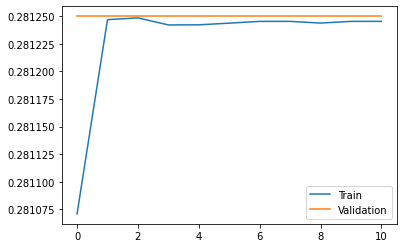

In [ ]:
plot_history(history.history)

Le modèle n'apprend malheureusement pas du tout.

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = from_scratch_model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 6s 32ms/step - loss: 0.2812 - accuracy_sim: 0.4997
Test loss: 0.28124552965164185
Test (binary) classification accuracy based on similarity: 0.4996579587459564


Le modèle n'est pas plus performant qu'un modèle aléatoire. En effet, rappelons que le jeu test est composé de 50% de paires positives et 50% de paires négatives, donc un modèle qui donnerait en sortie la même réponse (par exemple 1) donnerait une accuracy de 0.5.

### Pre-trained

Nous essayons maintenant un modèle pré-entrainé.

VGG16 : entraîné sur plus de 14 million d'images en haute résolution appartenant à 1000 classes différentes.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

On souhaite récupérer les couches de convolution du VGG16 pré-entraîné, pas la partie classifieur. Autrement dit, on souhaite utiliser les caractéristiques que le modèle a réussi à trouver. On intégre ces couches dans le `shared_conv` du modèle siamois.

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(60, 60, 3))
vgg16.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
class SharedConvPretrained(tf.keras.Model):
    def __init__(self, config, backbone):
        super().__init__(self, name="sharedconvpretrained")

        self.config = config
        self.backbone = backbone
        self.flatten = Flatten()
        self.dense_layers = [Dense(units, activation=activation) for units, activation in config.dense_layers]
        
    def call(self, x):

        x = self.backbone(x)
        x = self.flatten(x)
        for dense in self.dense_layers:
            if self.config.use_dropout:
                x = Dropout(0.5)(x)
            x = dense(x)
        return x

In [ ]:
def create_pretrained_siamese_model(config, backbone=vgg16):
    shared_conv = SharedConvPretrained(config, backbone)
    model = Siamese(shared_conv)
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy_sim])
    return model

In [ ]:
config1 = ModelConfig(
    conv_layers=[],
    dense_layers=[(100, "relu"), (50, "sigmoid")],
    use_pool = False,
    use_dropout = True
)

In [ ]:
pretrained_model = create_pretrained_siamese_model(config1)
#pretrained_model.load_weights(f"{DRIVE_PATH}/models/pretrained_1.ckpt")

In [ ]:
num_model = 1
best_model_fname = f"{DRIVE_PATH}/models/final_pretrained_{num_model}.ckpt"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_accuracy_sim',
                                save_best_only=True, save_weights_only=True, verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=10) # Stop the training when no improv in val_loss for 10 epochs

In [ ]:
history = pretrained_model.fit(x=train_gen, 
          epochs=50,
          validation_data=((val_X1, val_X2), val_Y),
          callbacks=[best_model_cb, early_stopping_cb], verbose=1)

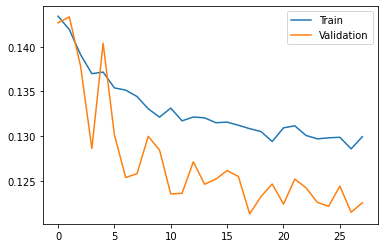

In [ ]:
plot_history(history.history)

Le modèle apprend beaucoup mieux que le précédent, puisque la loss diminue.

In [ ]:
# Evaluation on test set
test_loss, test_acc_sim = pretrained_model.evaluate(x=(test_X1, test_X2), y=test_Y, batch_size=32)
print(f"Test loss: {test_loss}")
print(f"Test (binary) classification accuracy based on similarity: {test_acc_sim}")

201/201 [==============================] - 8s 35ms/step - loss: 0.1189 - accuracy_sim: 0.5983
Test loss: 0.1188737004995346
Test (binary) classification accuracy based on similarity: 0.5982587337493896


Nous obtenons une accuracy bien supérieure au modèle précédent. Néanmoins, la performance reste encore assez faible.

# 3.Attaques adverses : FGSM


Dans cette partie, nous implémentons une attaque FGSM, qui est une attaque qui s'applique lors de la phase d'inférence et qui de type white-box, c'est-à-dire que nous avons accès au modèle (poids, gradients...) que l'on souhaite attaquer.

Le modèle à attaquer est un modèle siamois, qui prend en entrée une paire d'images $(x_1, x_2)$, donc notre fonction d'attaque doit également prendre en entrée une paire d'images. On donnera précisemment une paire d'IDs issus des variables `X1_ids_test` et `X2_ids_test`. 


Puisque l'attaque se joue lors de la phase de test, on souhaite construire un jeu de données test d'images attaquées. 


Par anticipation de la comparaison des performances entre les modèles non attaqués et attaqués, nous devons construire un test set d'IDs commun pour la tâche de classification. Tout d'abord, les IDs dans ce test set doivent représenter des personnes avec au moins deux images distinctes (puisqu'on devra trouver l'image la plus similaire excepté l'image elle-même). Ensuite, nous avons le choix entre attaquer les images dans `X1_ids_test` et/ou dans `X2_ids_test`. Ici, nous allons nous restreindre aux images qui sont dans `X1_ids_test` à cause d'une limite de temps et de mémoire. 
Le jeu test `X_test` sera donc construit à partir de `X1_ids_test` car ce sont les images que nous pouvons attaquer, et seulement les IDs des personnes avec plus d'une image seront conservés.


### Construction du test set

On construit notre jeu de données test pour la classification à cette étape, en fonction des images que l'on peut attaquer, c'est-à-dire celles que l'on trouve dans `X1_ids_test`.

In [ ]:
# List of images IDs of people with more than one image that appeared in X1_ids_test
X_test = []
for img_id in X1_ids_test:
    class_id = id_to_classid[img_id]
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        X_test.append(img_id)
X_test = list(set(X_test))

In [ ]:
# Ground truth labels of images in X_test
Y_test = [id_to_classid[i] for i in X_test]

In [ ]:
# Classes in X_test
X_test_classes = list(set(Y_test))


Pour pouvoir récupérer les images attaquées de chaque image du test set, on construit un dictionnaire `testid_to_idx_in_X1_ids_test` qui associe à chaque ID de `X_test`, un array d'indices de `X1_ids_test` qui correspond au même ID. 

In [ ]:
testid_to_idx_in_X1_ids_test = defaultdict()
for id in X_test:
    idx = np.where(X1_ids_test == id)[0]
    testid_to_idx_in_X1_ids_test[id] = idx

In [ ]:
def show_dataset_and_attacks(x, x_attack):
    plt.figure(figsize=(20, 5))

    num_images_one_row = len(x_attack.keys())
    for i, epsilon in enumerate(x_attack.keys()):
        plt.subplot(2, num_images_one_row, i + 1)
        plt.imshow(all_imgs[x[0]] / 255)
        plt.title(r"$\epsilon$"+f'={epsilon}')
        plt.axis('off')

        plt.subplot(2, num_images_one_row, i + 1 + num_images_one_row)
        idx = testid_to_idx_in_X1_ids_test[x[0]][0]
        plt.imshow(x_attack[epsilon][idx] / 255)
        plt.axis('off')
        
    plt.show()

### Choix de epsilon

La fonction suivante permet de générer des images visuellement similaires aux images originales à l'aide de l'algorithme FGSM. On attaque seulement les premières images des paires données en entrée de nos modèles siamois.

In [ ]:
def fgsm_siamese_attack(x1_numpy, x2_numpy, y, epsilon, model):
    x1 = tf.constant(np.expand_dims(x1_numpy, 0), dtype=tf.float32)
    x2 = tf.constant(np.expand_dims(x2_numpy, 0), dtype=tf.float32)

    with tf.GradientTape(persistent=True) as g: 
        g.watch(x1)
        y_pred = model((x1, x2))
        loss = contrastive_loss(y_true=y, y_pred=y_pred)
        dloss_dx1 = g.gradient(loss, x1)
        gradient = np.sign(dloss_dx1) # shape (1, 60, 60, 3) avec que des 1 ou -1
        x_attack = x1 + epsilon * gradient # shape (1, 60, 60, 3)
        x_attack = np.reshape(x_attack, (60, 60, 3))
        x_attack = np.clip(np.floor(x_attack), 0, 255)
        
    return x_attack

On teste plusieurs valeurs d'epsilon afin de décider pour quelles valeurs l'attaque est non discernable à l'oeil nu.

In [ ]:
epsilon_vals = [0.5, 1, 2, 3, 5, 10, 20, 50]

__From scratch__

In [ ]:
x_fgsm = defaultdict()
for epsilon in epsilon_vals:
    x_fgsm[epsilon] = [fgsm_siamese_attack(all_imgs[X1_ids_test[idx]], all_imgs[X2_ids_test[idx]], test_Y[idx], epsilon=epsilon, model=from_scratch_model) for idx in tqdm(range(30))]

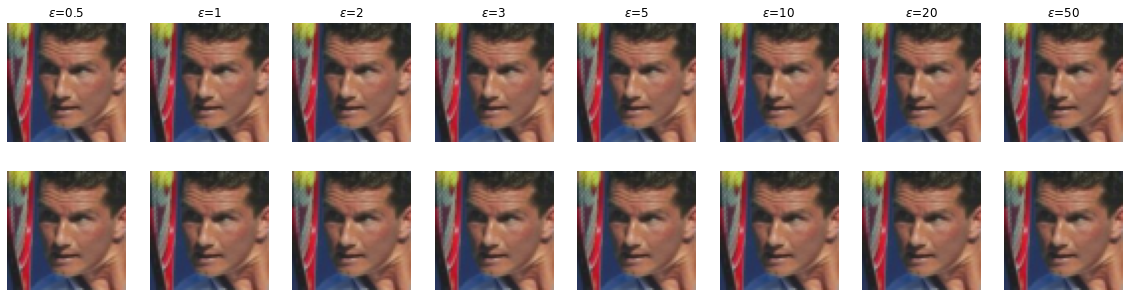

In [ ]:
show_dataset_and_attacks(X_test, x_fgsm)

Etrangement, les images générées par l'attaque ne semblent pas se différencier des images originales, et ce même pour des valeurs différentes d'epsilon. Le problème réside sûrement dans le modèle entraîné from scratch.

__Pre-trained__

In [ ]:
x_fgsm = defaultdict()
for epsilon in epsilon_vals:
    x_fgsm[epsilon] = [fgsm_siamese_attack(all_imgs[X1_ids_test[idx]], all_imgs[X2_ids_test[idx]], test_Y[idx], epsilon=epsilon, model=pretrained_model) for idx in tqdm(range(30))]

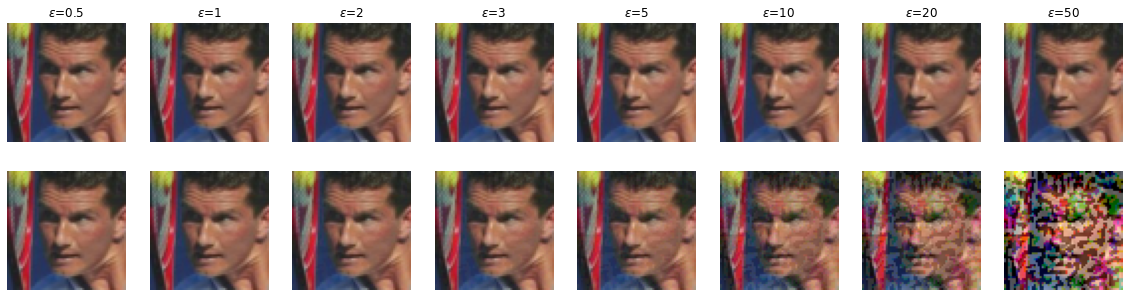

In [ ]:
show_dataset_and_attacks(X_test, x_fgsm)

Nous pouvons observer qu'avec des valeurs grandes d'epsilon, les images générées par l'attaque sont très discernables à l'oeil nu puisque la perturbation est beaucoup plus grande. 

Dans la suite, on génèrera des attaques en fixant epsilon à 1 ou 3, pour chacun des modèles.

### Génération des attaques

Rappelons nous que pour chaque modèle, nous avons seulement attaqué les images contenus dans `X1_ids_test`, certaines étant répétées dans ce jeu. 
Comme expliqué un peu plus haut, on construit un jeu test d'images attaqués en conservant seulement les IDs des personnes qui ont plus d'une image dans le jeu de données de départ.

Ensuite pour pouvoir classifier nos images test, on doit obtenir les embeddings de ces images déduits par chacun des modèles. On calculera par la suite un score de similarité entre cet embedding et l'embedding de chaque image du jeu de départ pour décider s'il s'agit ou non de la même personne.

In [ ]:
def get_attacked_test_images(all_x1_attacked):
    x_test_attacked = defaultdict(list)
    for epsilon in all_x1_attacked.keys(): 
        for id in X_test:
            idx = testid_to_idx_in_X1_ids_test[id][0] # Get the index of the 1st image among all images of ID=id
            x_test_attacked[epsilon].append(all_x1_attacked[epsilon][idx])
        x_test_attacked[epsilon] = np.array(x_test_attacked[epsilon]) 
    return x_test_attacked 

In [ ]:
def get_emb_attacked_imgs(x_test_attacked, model):
    emb_attacked = defaultdict()
    for epsilon in x_test_attacked.keys():
        emb_attacked[epsilon] = model.shared_conv.predict(x_test_attacked[epsilon])
    return emb_attacked 

In [ ]:
chosen_epsilon = [1, 3]

__From scratch__

In [ ]:
x_fgsm_scratch = defaultdict()
for epsilon in chosen_epsilon:
    x_fgsm_scratch[epsilon] = [fgsm_siamese_attack(all_imgs[X1_ids_test[idx]], all_imgs[X2_ids_test[idx]], test_Y[idx], epsilon=epsilon, model=from_scratch_model) for idx in tqdm(range(len(X1_ids_test)))]

In [ ]:
x_test_fgsm_scratch = get_attacked_test_images(x_fgsm_scratch)
emb_fgsm_scratch = get_emb_attacked_imgs(x_test_fgsm_scratch, from_scratch_model)

#x_test_fgsm_scratch = load_pickle("x_test_fgsm_scratch.pkl", model_dir)
#emb_fgsm_scratch = load_pickle("emb_fgsm_scratch.pkl", model_dir)

__Pre-trained__

In [ ]:
x_fgsm_pretrained = defaultdict()
for epsilon in chosen_epsilon:
    x_fgsm_pretrained[epsilon] = [fgsm_siamese_attack(all_imgs[X1_ids_test[idx]], all_imgs[X2_ids_test[idx]], test_Y[idx], epsilon=epsilon, model=pretrained_model) for idx in tqdm(range(len(X1_ids_test)))]

In [ ]:
x_test_fgsm_pretrained = get_attacked_test_images(x_fgsm_pretrained)
emb_fgsm_pretrained = get_emb_attacked_imgs(x_test_fgsm_pretrained, pretrained_model)

#x_test_fgsm_pretrained = load_pickle("x_test_fgsm_pretrained.pkl", model_dir)
#emb_fgsm_pretrained = load_pickle("emb_fgsm_pretrained.pkl", model_dir)

# 4.Evaluation



Nos modèles ne performant pas, l'évaluation de ces derniers ne sera pas aussi parlante que ce que nous aurions souhaité.
Néanmoins, nous avons pensé à des métriques différentes.

Lors de l'évaluation du classifier, il est important de faire attention au fait que les classes soient déséquilibrées. En effet, s'il existe une classe fortement majoritaire (une personne avec beaucoup de photos) et que le classifieur prédit toujours cette classe, l'accuracy sera bonne, alors que le classifieur ne l'est en réalité pas. Nous essayons les métriques suivantes : 

**1. Precision (macro, weighted) et Recall (macro, weighted)**


Lorsque l'on effectue de la classification binaire, il existe plusieurs métriques pour mesurer les performances. Notamment :

- Accuracy : (TP+TN)/(TP+TN+FP+FN) -- Quelle proportion des samples (positifs et negatifs) sont correctement classifiés ?
- Precision : TP / (TP + FP) -- Quelle proportion des prédictions positives sont réellement positives ?
- Recall : TP / (TP + FN) -- Quelle proportion des positives sont correctement classifiées ? 

avec TP le nombre d'exemples positifs et classifiés positivement, TN le nombre d'exemples négatifs et classifiés négativement, FP le nombre d'exemples positifs et classifiés négativement, et FN, le nombre d'exemple négatifs et classés positivement.

L'accuracy est la métrique habituelle.
Il est particulièrement pertinent de mesurer des performances avec le recall lorsqu'on ne veut absolument pas louper d'exemples positifs. Dans le cas de la détection de fraude par exemple, on préfère identifier comme une fraude une action qui n'en est pas une en réalité plutot que de la manquer.

La précision est la plus pertinente au contraire lorsqu'on ne veut surtout pas identifier comme positif un exemple qui était négatif. C'est le cas par exemple lors d'un système de sécurité par reconnaissance faciale : on préfère ne pas laisser entrer quelqu'un qui aurait du pouvoir rentrer plutot que de laisser rentrer quelqu'un qui ne devrait pas.

Dans le cadre de la classification de personnes, la métrique choisie dépendra de l'utilité du classifieur. Dans le cadre des JO, on peut imaginer qu'il s'agit d'enjeux de sécurité et donc qu'on préfèrerait la précision.

Lors d'un problème multi-classe à $N$ classes, on calcule la précision et le recall pour chaque classe (en considérant que la classe positive est la classe en question, et la classe négative tout le reste). 

Nous disposons alors de $N$ précisions et $N$ recall. Là encore, il convient de faire attention à la manière dont nous allons agréger les métriques. En effet, encore une fois, une classe majoritaire peut complètement déséquilibrer la métrique. Si on se contente d'une moyenne (méthode macro-averaged), on peut se heurter à l'exemple suivant : 

- un classifieur 1 qui a bien classifié 1 fois 2 personnes qui apparaissent 1 seule fois dans le test set mais jamais bien classifié deux personnes qui apparaissent 20 fois dans le test set aura une précision de (1/1 + 1/1 + 0/20 + 0/20)/4 = 0.5
- un classifieur 2 qui n'aura jamais bien classifié deux personnes qui apparaissent une fois, et toujours bien classifié deux personnes qui apparaissent 20 fois aura une précision de (0/1 + 0/1 + 20/20 + 20/20)/4 = 0.5

Les deux classifieurs ont la même précision aggrégée. Néanmoins, le second peut sembler meilleur puisque même s'il n'a réussi à identifier parfaitement que la moitié des personnes, il a réussi à le faire sur plus de photos que le premier modèle.

Une autre idée peut donc être de pondérer les résultats par le nombre de photos. Pour les deux exemples précédents on aurait alors :

- classifieur 1 : (1*(1/1) + 1*(1/1) +20*(0/20) + 20*(0/20))/42 = 0.05
- classifieur 2 : (1*(0/1) + 1*(0/1) +20*(20/20) + 20*(20/20))/42 = 0.95



**2. Accuracy@k**

Enfin, une autre manière d'évaluer un modèle est la suivante :
lorsqu'on va chercher à classifier une image, on va sortir le top k des images les plus similaires. Si une image de la bonne classe se trouve dans le top k, on considère alors que l'image est bien classée. Cette mesure donne un peu plus de flexibilité au modèle. Néanmoins, lorsque le dataset est très déséquilibré, cela peut encore poser problème.




### **Fonctions pour l'évaluation**

In [ ]:
# Gather the ids of all images that are used for train and test
all_ids_train = list(set(X1_ids_train) | set(X2_ids_train))
all_ids_val = list(set(X1_ids_val) | set(X2_ids_val))
all_ids_test = list(set(X1_ids_test) | set(X2_ids_test))

Les fonctions suivantes serviront à l'évaluation des classifieurs. L'argument `emb` correspond à l'embedding de toutes les images du jeu de données de départ par chaque modèle. 

Lors de la classification d'une image $x$, on la compare à chaque image du dataset, c'est la raison pour laquelle on récupère l'embedding de chaque image.

In [ ]:
def most_sim(idx, emb, topn=5):
    x = emb[idx]
    x = x / np.linalg.norm(x)
    sims = np.dot(emb, x)
    ids = np.argsort(sims)[::-1]
    return [(id, sims[id]) for id in ids[:topn]]

def accuracy_k(emb=None, k=10, mode="embedding"):
    num_found = 0
    for img_idx in X_test:
        image_class = id_to_classid[img_idx]
        found_classes = []
        if mode == "embedding":
            found_classes = [id_to_classid[x] for (x, score) in most_sim(img_idx, emb, topn=k+1)[1:]]
        elif mode == "random":
            found_classes = [id_to_classid[x] for x in random.sample(
                list(set(all_ids_test + all_ids_val + all_ids_train) - {img_idx}), k)]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(X_test)

def predict_ground_truth(emb=None, mode="embedding"):
    
    # Compute y_pred = estimated targets 
    y_pred = []
    for img_idx in X_test:
        image_class = id_to_classid[img_idx]
        if mode == "embedding":
            x = most_sim(img_idx, emb, topn=2)[1:][0][0] # [1:] pour ne pas prendre l'image elle meme
        elif mode == "random":
            x = random.sample(list(set(all_ids_test + all_ids_val + all_ids_train) - {img_idx}), 1)[0]
        predicted_class = id_to_classid[x]
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    return y_pred

Les fonctions suivantes serviront à l'évaluation de l'attaque. L'argument `emb_adv` correspond à l'embedding de toutes les images attaquées.

In [ ]:
def most_sim_adv(idx, emb_adv, emb, topn=5):
    x = emb_adv[idx]
    x = x / np.linalg.norm(x)
    sims = np.dot(emb, x)
    ids = np.argsort(sims)[::-1]
    return [(id, sims[id]) for id in ids[:topn]]

def accuracy_k_adv(X_test, emb_adv, emb, k=10):
    num_found = 0
    for img_idx, img_id in enumerate(X_test):
        image_class = id_to_classid[img_id]
        found_classes = [id_to_classid[x] for (x, score) in most_sim_adv(img_idx, emb_adv, emb, topn=k+1)[1:]]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(X_test)

def predict_ground_truth_adv(X_test, emb_dict, emb):
    # Compute y_pred = estimated targets 
    y_pred = []
    for img_idx, img_id in enumerate(X_test):
        predicted_id = most_sim_adv(img_idx, emb_dict, emb, topn=2)[1:][0][0] # [1:] pour ne pas prendre l'image elle meme
        predicted_class = id_to_classid[predicted_id]
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    return y_pred

In [ ]:
def get_evaluation_metrics(y_pred, y_true, labels, average_modes):
    scores = {}
    for average_mode in average_modes:
        scores[f'{average_mode}-recall'] = recall_score(y_true, y_pred, labels=labels, average=average_mode)
        scores[f'{average_mode}-precision'] = precision_score(y_true, y_pred, labels=labels, average=average_mode)
    return scores

### Evaluation des classifieurs 

Dans un premier temps, nous évaluons la performance des modèles sur la tâche de classification, que l'on compare avec un modèle aléatoire.

In [ ]:
k_vals = [1, 5, 10, 20]
average_modes=["macro", "weighted"]

In [ ]:
# Create all images embeddings of the model trained from scratch

all_emb_scratch = from_scratch_model.shared_conv.predict(all_imgs)
all_emb_scratch = all_emb_scratch / np.linalg.norm(all_emb_scratch, axis=-1, keepdims=True)
save_as_pickle("all_emb_scratch.pkl", data_dir, all_emb_scratch)
#all_emb_pretrained = load_pickle("pretrained_1_emb.pkl", model_dir)

In [ ]:
# Create all images embeddings of the pre-trained model

all_emb_pretrained = pretrained_model.shared_conv.predict(all_imgs)
all_emb_pretrained = all_emb_pretrained / np.linalg.norm(all_emb_pretrained, axis=-1, keepdims=True)
save_as_pickle("all_emb_pretrained.pkl", data_dir, all_emb_pretrained)
#all_emb_pretrained = load_pickle("pretrained_1_emb.pkl", model_dir)

__1. Baseline (random)__

In [ ]:
print("Baseline results")
for k in k_vals:
    print(f'k={k} -- {accuracy_k(k=k, mode="random")}')

Baseline results
k=1 -- 0.0006591957811470006
k=5 -- 0.00922874093605801
k=10 -- 0.017139090309822018
k=20 -- 0.017139090309822018


In [ ]:
y_pred_rand = predict_ground_truth(mode="random")
scores_rand = get_evaluation_metrics(y_pred=y_pred_rand, y_true=Y_test, labels=X_test_classes, average_modes=average_modes)

In [ ]:
scores_rand

{'macro-precision': 0.006087824351297405,
 'macro-recall': 0.00088467801239626,
 'weighted-precision': 0.02417051197539002,
 'weighted-recall': 0.0026367831245880024}

__2. From scratch__

In [ ]:
print("From scratch results")
for k in k_vals:
    print(f'k={k} -- {accuracy_k(emb=all_emb_scratch, k=k, mode="embedding")}')

From scratch results
k=1 -- 0.0
k=5 -- 0.0
k=10 -- 0.0
k=20 -- 0.0


In [ ]:
y_pred_scratch = predict_ground_truth(all_emb_scratch, mode="embedding")
scores_scratch = get_evaluation_metrics(y_pred=y_pred_scratch, y_true=Y_test, labels=X_test_classes, average_modes=average_modes)

In [ ]:
scores_scratch

{'macro-precision': 0.0,
 'macro-recall': 0.0,
 'weighted-precision': 0.0,
 'weighted-recall': 0.0}

Le modèle entraîné from scratch est extremement mauvais : il n'arrive pas du tout à classifier nos images, et nous avons quelques difficultés à trouver la raison qui pourrait expliquer un tel résultat.

__3. Pre-trained__

In [ ]:
print("Pre-trained results")
for k in k_vals:
    print(f'k={k} -- {accuracy_k(all_emb_pretrained, k, "embedding")}')

Pre-trained results
k=1 -- 0.02109426499670402
k=5 -- 0.061305207646671064
k=10 -- 0.08767303889255108
k=20 -- 0.13117996044825314


In [ ]:
y_pred_pretrained = predict_ground_truth(all_emb_pretrained, mode="embedding")
scores_pretrained = get_evaluation_metrics(y_pred=y_pred_pretrained, y_true=Y_test, labels=X_test_classes, average_modes=average_modes)

In [ ]:
scores_pretrained

{'macro-precision': 0.04529868833761049,
 'macro-recall': 0.017675817848381476,
 'weighted-precision': 0.0948064789528204,
 'weighted-recall': 0.02109426499670402}

Le modèle pre-trained a de bien meilleurs résultats que les deux autres modèles tant sur l'accuracy@k que sur les métriques de précision et recall.

Dans le cadre de la reconnaissance faciale, nous préférons une plus haute précision qu'un recall élevé, puisqu'on ne voudrait pas identifier un exemple négatif comme un positif. 
Cependant, nos résultats ne sont pas très significatifs afin que nous puissions en tirer des conclusions intéressantes.

### Evaluation de l'attaque

__From scratch__

In [ ]:
for epsilon in chosen_epsilon:
    print(f'----- Epsilon = {epsilon} -----')
    for k in k_vals:
        print(f'k={k}', accuracy_k_adv(X_test, emb_fgsm_scratch[epsilon], all_emb_scratch, k=k))

----- Epsilon = 1 -----
k=1 0.0
k=5 0.0
k=10 0.0
k=20 0.0
----- Epsilon = 3 -----
k=1 0.0
k=5 0.0
k=10 0.0
k=20 0.0


In [ ]:
scores_scratch = []
for epsilon in emb_fgsm_scratch.keys():
    y_pred = predict_ground_truth_adv(X_test, emb_fgsm_scratch[epsilon], all_emb_scratch)
    scores_scratch.append(get_evaluation_metrics(y_pred=y_pred, y_true=Y_test, labels=X_test_classes, average_modes=average_modes))

In [ ]:
scores_scratch

[{'macro-precision': 0.0,
  'macro-recall': 0.0,
  'weighted-precision': 0.0,
  'weighted-recall': 0.0},
 {'macro-precision': 0.0,
  'macro-recall': 0.0,
  'weighted-precision': 0.0,
  'weighted-recall': 0.0}]

Malheureusement, avec des scores de 0, nous ne pouvons comparer le modèle non attaqué à celui attaqué.

__Pre-trained__

In [ ]:
for epsilon in chosen_epsilon:
    print(f'----- Epsilon = {epsilon} -----')
    for k in k_vals:
        print(f'k={k}', accuracy_k_adv(X_test, emb_fgsm_pretrained[epsilon], all_emb_pretrained, k=k))

----- Epsilon = 1 -----
k=1 0.03032300593276203
k=5 0.10481212920237311
k=10 0.15425181278839814
k=20 0.22412656558998023
----- Epsilon = 3 -----
k=1 0.0032959789057350032
k=5 0.01911667765326302
k=10 0.037574159525379035
k=20 0.06657877389584707


```
Accuracy@k pre-trained results before attack
k=1 -- 0.02109426499670402
k=5 -- 0.061305207646671064
k=10 -- 0.08767303889255108
k=20 -- 0.13117996044825314
```

On remarque qu'en fixant $\epsilon=1$, nous obtenons de meilleurs résultats après attaque qu'avant attaque. Par exemple, avec $k=20$, nous obtenons une accuracy de 22% après attaque, alors qu'elle n'était qu'à 13% avant. Ces résultats sont très étranges, car cela signifie que tout d'abord l'attaque ne fonctionne pas du tout et que deuxièment les perturbations auraient permis d'améliorer la performance.

Par contre, en fixant $\epsilon=3$, l'attaque fonctionne beaucoup mieux puisque les performances diminuent. Avec $k=20$, on passe de 13% à 6%. Ainsi avec des images un peu plus perturbées, mais qui ne sont pas discernables à l'oeil nu, le modèle pré-entrainé est facilement attaquable. Il est donc très peu robuste.

In [ ]:
scores = []
for epsilon in emb_fgsm_pretrained.keys():
    y_pred = predict_ground_truth_adv(X_test, emb_fgsm_pretrained[epsilon], all_emb_pretrained)
    scores.append(get_evaluation_metrics(y_pred=y_pred, y_true=Y_test, labels=X_test_classes, average_modes=average_modes))

In [ ]:
scores

[{'macro-precision': 0.07601236920099194,
  'macro-recall': 0.028441201456099283,
  'weighted-precision': 0.1302948735875565,
  'weighted-recall': 0.03032300593276203},
 {'macro-precision': 0.009495295124037639,
  'macro-recall': 0.0028342685697786813,
  'weighted-precision': 0.012778981071664,
  'weighted-recall': 0.0032959789057350032}]

```
Precision and recall results before attack
{'macro-precision': 0.04529868833761049,
 'macro-recall': 0.017675817848381476,
 'weighted-precision': 0.0948064789528204,
 'weighted-recall': 0.02109426499670402}
 ```

Nous pouvons tirer les mêmes conclusions que précedemment.

# Conclusion

Afin de résoudre la tâche de classification, nous avons tenté de passer par la vérification. Malheureusement, nous avons rencontré de nombreux problèmes nous ralentissant beaucoup et n'avons pas pu mener toutes les expériences que nous aurions souhaité, dans le temps à notre disposition, et surtout avec les ressources de calcul à notre disposition (un ordinateur portable).
 
Néanmoins, nous pouvons noter plusieurs points :
 
- Pour notre dataset, nous avons choisi tout d'abord LFW, puisque c'est un dataset sur lequel nous avons déjà travaillé et nous le connaissons donc. Nous voulions l'utiliser comme baseline, et éventuellement l'augmenter en utilisant d'autres datasets, en allant sélectionner des photos sur internet (il est simple de trouver plusieurs photos de célébrités) voire en utilisant des photos de nous ! Cela nous aurait permis de prendre des photos différentes et jouer sur différents critères (luminosité, face/profil, flou, sourire, chapeau, perruque, maquillage, etc). Avec les difficultés rencontrées, nous n'avons malheureusement pas eu le temps d'agrémenter notre dataset et de réaliser différents tests.
 
- La constitution des ensembles d'entraînement, de test, et de validation est un point majeur lors de cette tâche. C'est en effet un élément qu'il faut anticiper, en particulier parce qu'il faut prendre en compte le fait que notre tâche intermédiaire est évaluée sur des paires, tandis que notre tâche finale est évaluée sur des images seules.
 
- Nous avons pensé pertinent de faire de la data augmentation. Nous avons testé plusieurs augmentations differentes ainsi que sans augmentation. Nous avons pu remarquer que trop de déformation dans les données faisaient sous performer le modèle. Néanmoins, nous avions d'un peu meilleurs résultats avec de légères modifications aléatoires, que sans modifications du tout. Nous avons pensé que des augmentations en jouant sur le flou et sur la luminosité des images seraient le plus pertinent, puisque cela représente bien les différences qu'on peut observer dans des photos de visages. Au contraire, des distorsions peuvent avoir un effet négatif : puisqu'il y a assez peu de photos pour chaque classe en général, il était sans doute préférable de garder les images initiales, afin que le réseau ne rate pas des détails importants.
 
- Nous avons essayé plusieurs modèles ad hoc. Nous avons notamment essayé des modèles similaires à ceux vus en TP, puis nous avons essayé de les complexifier. Nous avons également essayé un modèle plus personnalisé, plus profond, en réfléchissant plus en détails à la taille des kernel, du padding, etc. Nous avons également rencontré des difficultés lors de la conception de certains modèles, ce qui, encore une fois, nous a empêché d'essayer toutes nos idees. Malheureusement, aucun des modèles que nous avons essayé n'a réussi à apprendre. Il aurait sans doute fallu un réseau plus complexe et/ou plus d'entraînement. Les modèles ainsi conçus sont donc aussi performants que des modèles aléatoires. En pratique, ils prédisent toujours la même classe, et puisque les datasets sont équilibrés, on trouve une accuracy de 50%.
 
- Lors de l'utilisation d'un modèle pretrained, nous avons noté une amélioration des performances, mais néanmoins des performances assez faibles. Le modèle pré entrainé que nous avons utilisé a été entrainé sur de nombreuses images sur une tâche de classification. Néanmoins, parmi ces nombreuses images, il n'y avait pas de classe "humain", ou "homme, "femme", etc. Nous ne savons pas exactement combien d'humains a vu VGG16 lors de son entrainement, mais il est certain que cela ne constitue pas la majorité des données, en particulier pour les visages. Par ailleurs, il a été entrainé pour distinguer des types de personnes (un cow-boy d'un indien par exemple) mais pas vraiment pour distinguer des personnes en particulier. Il est donc très probable que ce modèle ne se soit jamais entrainé pour distinguer des caractéristiques de visages. L'utilisation d'un modèle pré entrainé permet de partir sur une certaine base, puisque le modèle sait déjà comment traiter des images, mais n'est pas miraculeuse. Pour ré-entraîner ce modèle sur nos données, nous avons également essayé plusieurs manières. Pour plusieurs de nos tentatives, nous ne notions aucun apprentissage. C'est un des modèles les plus simples que nous avons essayé qui nous a permis d'obtenir une accuracy de 60% sur la tâche de vérification.

- Concernant les attaques, nous avons voulu essayer différentes normes (notamment la norme l2) mais nos données redimensionnées étant en très petites dim, l'espace d'attaque en norme l2 et ∞ se superposent (en 2D, la norme l2 représenté un cercle autour de l'image, et en norme ∞ un carré). Nous nous sommes donc concentrées sur la norme ∞. Dans ce projet, nous avons seulement essayé FGSM, mais nous aurions pu comparer avec d'autres algorithmes SOTA tels que BIM, DeepFool etc. ou encore des modèles de type black-box, ou des modèles d'attaques pendant la phase d'entraînement. Nos classifieurs ne semblant pas robustes, ces attaques auraient surêment été encore plus efficaces.
 
- Pour évaluer nos modèles, il est important de prendre en compte le fait que les classes soient équilibrées ou non, mais également l'utilisation finale du modèle (notamment s'il s'agit d'un contexte de détection de signal ou de sécurité par exemple). Nos classes étaient effectivement assez déséquilibrées, puisque certaines personnes avaient des dizaines de photos (voire des centaines), quand la plupart n’en avaient qu’une ou deux. Nous avons donc voulu essayer des métriques différentes de l’accuracy. N’ayons pas non plus de contexte particulier, nous avons essayé autant le recall que la précision. Nous avons également essayé une autre métrique, l’accuracy@k, qui nous semblait particulièrement adaptée : puisque nos modèles n’étaient pas très performants, en faisant varier k nous pouvions mesurer un peu plus loin les performances de notre algorithme.



Nous avons rencontré une grande difficulté quant à la gestion des tests sets, et avons malheureusement réalisé assez tard que nous n'avions pas appliqué un seed pour permettre la reproductibilité de nos expériences entre chaque lancement. Les tests sets étaient donc différents à chaque relancement.